In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.nn.functional import cosine_similarity

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:


# Load data
train_data = torch.load('train.pt')
val_data = torch.load('val.pt')
test_data = torch.load('test.pt')

# Prepare dataset
def prepare_dataset(data):
    eeg_list = []
    stim_list = []
    for eeg, stim in data:
        eeg_list.append(eeg.float())           # (320, 64)
        stim_list.append(stim.float())         # (320,)
    eeg_tensor = torch.stack(eeg_list)         # (N, 320, 64)
    stim_tensor = torch.stack(stim_list)       # (N, 320)
    return eeg_tensor, stim_tensor

X_train, y_train = prepare_dataset(train_data)
X_val, y_val = prepare_dataset(val_data)
X_test, y_test = prepare_dataset(test_data)



In [19]:
# Subsample 1% of the data
def subsample_data(X, y, fraction=1):
    n_samples = X.shape[0]
    n_subsample = max(1, int(n_samples * fraction))
    indices = np.random.permutation(n_samples)[:n_subsample]
    return X[indices], y[indices]

X_train_sub, y_train_sub = subsample_data(X_train, y_train, fraction=1)
print(f"Subsampled training data: X_train_sub {X_train_sub.shape}, y_train_sub {y_train_sub.shape}")

Subsampled training data: X_train_sub torch.Size([91381, 320, 64]), y_train_sub torch.Size([91381, 320])


In [20]:
# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_sub, y_train_sub)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [21]:
# Define the hybrid model
class EEG2EnvModel(nn.Module):
    def __init__(self):
        super(EEG2EnvModel, self).__init__()
        # CNN Block
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d((2, 2))  # Reduces spatial dims
        )
        # LSTM Block
        self.lstm = nn.LSTM(input_size=64*32, hidden_size=128, num_layers=2, 
                            batch_first=True, bidirectional=True)
        # Transformer Block
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=256, nhead=4, dim_feedforward=512, dropout=0.1),
            num_layers=2
        )
        # Output Layer
        self.fc = nn.Linear(256, 1)

    def forward(self, x):
        # x: (N, 320, 64) -> (N, 1, 320, 64)
        x = x.unsqueeze(1)  # (N, 1, 320, 64)
        x = self.cnn(x)  # (N, 64, 160, 32) after pooling
        x = x.permute(0, 2, 1, 3).reshape(x.size(0), x.size(2), -1)  # (N, 160, 64*32)
        x, _ = self.lstm(x)  # (N, 160, 256)
        x = self.transformer(x)  # (N, 160, 256)
        x = self.fc(x).squeeze(-1)  # (N, 160)
        # Upsample to 320
        x = nn.functional.interpolate(x.unsqueeze(1), size=320, mode='linear', align_corners=False).squeeze(1)
        return x

model = EEG2EnvModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Corrected metrics computation
def compute_metrics(y_true, y_pred):
    # Ensure inputs are tensors for cosine similarity
    cosine_sims = []
    for i in range(y_true.shape[0]):
        cosine_sim = cosine_similarity(y_true[i].reshape(1, -1), y_pred[i].reshape(1, -1)).item()
        cosine_sims.append(cosine_sim)
    
    # Convert to NumPy for other metrics
    y_true_np = y_true.cpu().numpy()
    y_pred_np = y_pred.cpu().numpy()
    
    mse = mean_squared_error(y_true_np.flatten(), y_pred_np.flatten())
    mae = mean_absolute_error(y_true_np.flatten(), y_pred_np.flatten())
    
    pearson_corrs = []
    for i in range(y_true_np.shape[0]):
        pearson, _ = pearsonr(y_true_np[i], y_pred_np[i])
        pearson_corrs.append(pearson)
    
    return mse, mae, np.mean(pearson_corrs), np.mean(cosine_sims), pearson_corrs, cosine_sims

/DATAHDD/chailex/anaconda3/envs/mtech_env/lib/python3.10/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [22]:
# Training and validation loop
num_epochs = 5
train_losses = []
val_losses = []
val_pearsons = []
val_cosines = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    train_progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
    for X_batch, y_batch in train_progress:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
        train_progress.set_postfix({'loss': loss.item()})
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0
    val_mse, val_mae, val_pearson, val_cosine = 0, 0, 0, 0
    val_progress = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
    with torch.no_grad():
        for X_batch, y_batch in val_progress:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            mse, mae, pearson, cosine, _, _ = compute_metrics(y_batch, outputs)
            val_mse += mse
            val_mae += mae
            val_pearson += pearson
            val_cosine += cosine
            val_progress.set_postfix({'loss': loss.item()})
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_pearsons.append(val_pearson / len(val_loader))
    val_cosines.append(val_cosine / len(val_loader))
    
    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
          f'Val MSE: {val_mse/len(val_loader):.4f}, Val MAE: {val_mae/len(val_loader):.4f}, '
          f'Val Pearson: {val_pearson/len(val_loader):.4f}, Val Cosine: {val_cosine/len(val_loader):.4f}')



Epoch 1/5 [Val]: 100%|████████████████████████████████████████████████████| 328/328 [00:09<00:00, 35.36it/s, loss=0.421]


Epoch 1: Train Loss: 0.2468, Val Loss: 0.2485, Val MSE: 0.2487, Val MAE: 0.4013, Val Pearson: 0.1084, Val Cosine: 0.8068


Epoch 2/5 [Val]: 100%|████████████████████████████████████████████████████| 328/328 [00:09<00:00, 34.60it/s, loss=0.414]


Epoch 2: Train Loss: 0.2224, Val Loss: 0.2484, Val MSE: 0.2485, Val MAE: 0.3999, Val Pearson: 0.1274, Val Cosine: 0.8079


Epoch 3/5 [Val]: 100%|████████████████████████████████████████████████████| 328/328 [00:09<00:00, 34.84it/s, loss=0.391]


Epoch 3: Train Loss: 0.2158, Val Loss: 0.2572, Val MSE: 0.2573, Val MAE: 0.3994, Val Pearson: 0.1452, Val Cosine: 0.8089


Epoch 4/5 [Val]: 100%|████████████████████████████████████████████████████| 328/328 [00:09<00:00, 34.77it/s, loss=0.381]


Epoch 4: Train Loss: 0.2118, Val Loss: 0.2596, Val MSE: 0.2598, Val MAE: 0.4094, Val Pearson: 0.1494, Val Cosine: 0.8100


Epoch 5/5 [Val]: 100%|████████████████████████████████████████████████████| 328/328 [00:09<00:00, 35.26it/s, loss=0.383]

Epoch 5: Train Loss: 0.2091, Val Loss: 0.2567, Val MSE: 0.2569, Val MAE: 0.4049, Val Pearson: 0.1589, Val Cosine: 0.8110


In [23]:
# Test evaluation
model.eval()
test_pearsons = []
test_cosines = []
test_predictions = []
test_trues = []
with torch.no_grad():
    test_progress = tqdm(test_loader, desc='Testing')
    for X_batch, y_batch in test_progress:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, _, _, _, pearson_corrs, cosine_sims = compute_metrics(y_batch, outputs)
        test_pearsons.extend(pearson_corrs)
        test_cosines.extend(cosine_sims)
        test_predictions.append(outputs.cpu().numpy())
        test_trues.append(y_batch.cpu().numpy())

        
test_predictions = np.concatenate(test_predictions)
test_trues = np.concatenate(test_trues)

Testing: 100%|████████████████████████████████████████████████████████████████████████| 788/788 [00:21<00:00, 37.00it/s]


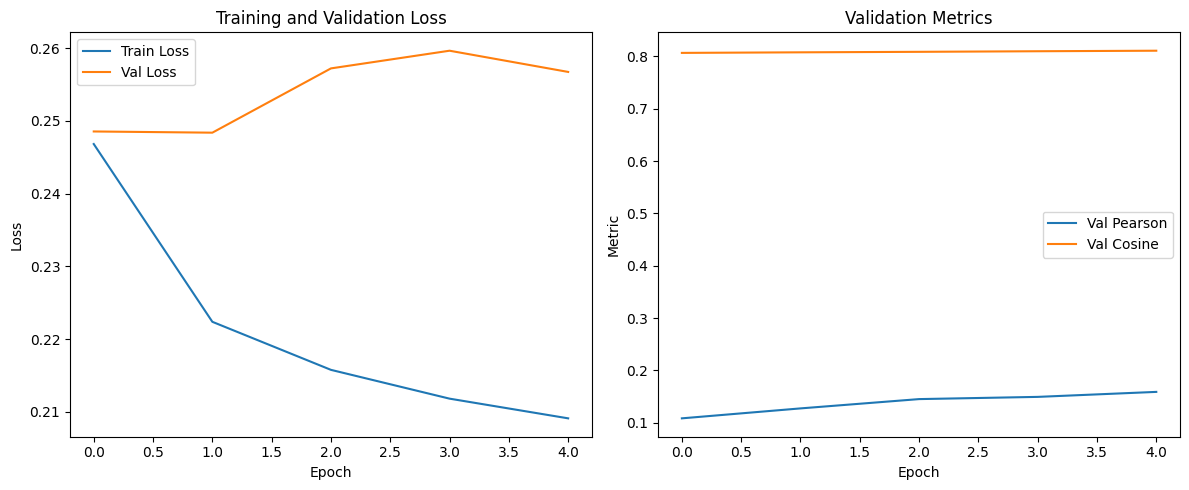

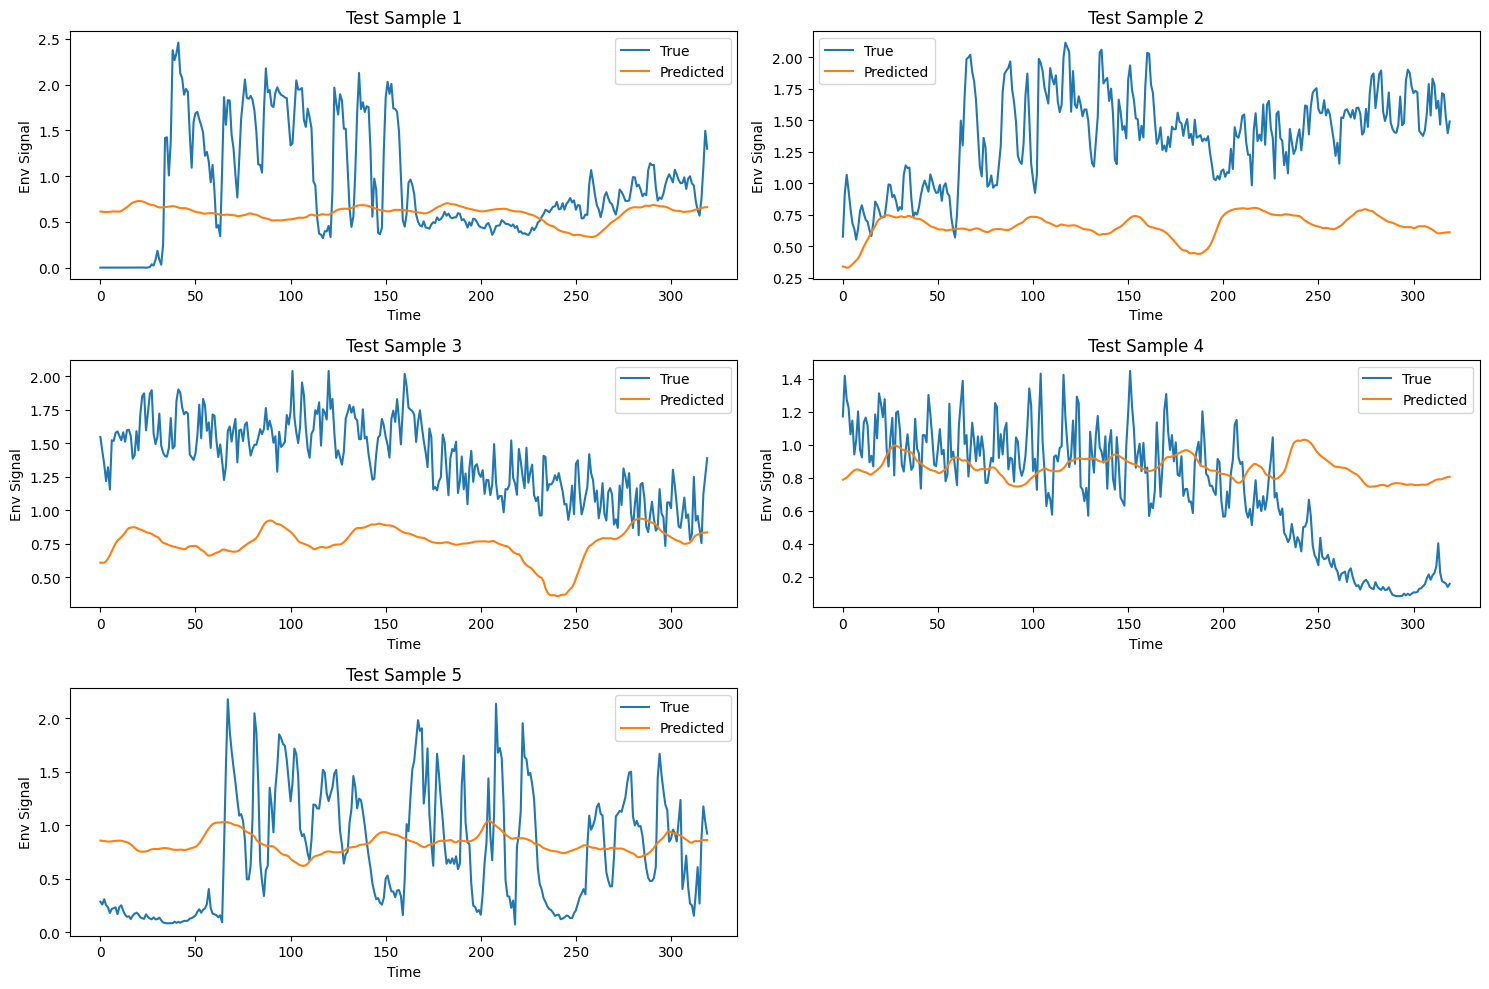

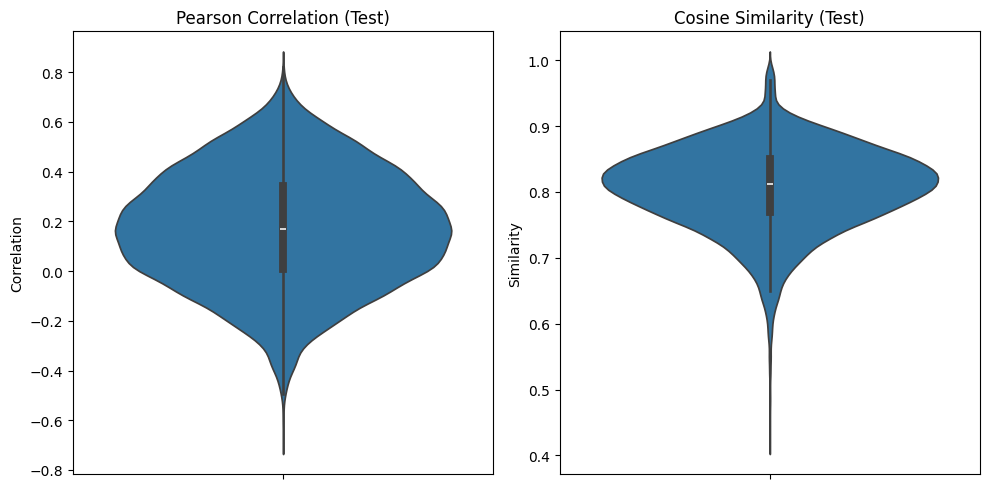

In [24]:
# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_pearsons, label='Val Pearson')
plt.plot(val_cosines, label='Val Cosine')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Validation Metrics')
plt.legend()
plt.tight_layout()
plt.savefig('training_curves.png')
plt.show()

# Plot regression for 5 test samples
plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(3, 2, i+1)
    plt.plot(test_trues[i], label='True')
    plt.plot(test_predictions[i], label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Env Signal')
    plt.title(f'Test Sample {i+1}')
    plt.legend()
plt.tight_layout()
plt.savefig('regression_plots.png')
plt.show()

# Violin plots for test metrics
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.violinplot(data=test_pearsons)
plt.title('Pearson Correlation (Test)')
plt.ylabel('Correlation')

plt.subplot(1, 2, 2)
sns.violinplot(data=test_cosines)
plt.title('Cosine Similarity (Test)')
plt.ylabel('Similarity')
plt.tight_layout()
plt.savefig('violin_plots.png')
plt.show()